# Frozen Lake: Policy

In reinforcement learning, an agent is acting in an environment, and learning by trial-and-error to optimize its performance in order to gain maximal cumulative reward. The behaviour of the agent in the environment is called the policy, and the goal is to find the optimal policy. In this notebook the Policy class is discussed.

## Import module ReinforcementLearning

Class "Policy" is also part of the "ReinforcementLearning" module, which is imported first, and which also imports packages "numpy" as "np" and "matplotlib.pyplot" as "plt". Matplotlib is set to the interactive "notebook" mode:

In [1]:
from ReinforcementLearning import *
%matplotlib notebook

## Creating environment and agent

To explain how a policy is created and applied, an environemt and an agent are needed. Therefore a FrozenLake object and an Agent object are constructed. The FrozenLake environment is deterministic to get a better understanding of how a  policy defines the agent's behaviour.

In [2]:
env = FrozenLake.make(is_slippery=False)
agent = Agent(env)

## Defining a policy 

A policy determines which action the agent will take when he is in a given state. Formally speaking, a policy maps states to actions. This means a policy is a function which accepts a state as input and returns an action as output. Because states and actions are discrete, a policy can be represented as a table or a matrix where each row corresponds to a state and each column to an action. Policies can be deterministic or stochastic. Given a certain state, a deterministic policy will always return the same action, whereas a stochastic policy selects the action randomly by sampling a known probability distribution.    

### Deterministic policy

Policies will be represented by a matrix with the number of rows equal to the number of states and the number of columns equal to the number of actions. If the policy is deterministic, then all entries in a row are zero, except the entry corresponding to the action that must be taken, which is one.

Defining a deterministic policy that puts the cursor in the terminal state G of the FrozenLake environment starts with constructing a 16 x 4 matrix containing zeros:

In [3]:
P = np.zeros((env.nstates, env.nactions))

Then the entries corresponding to a valid action to reach the final state G are set to one:

In [4]:
P[0, 1] = 1  # 0 -> down -> 4
P[4, 1] = 1  # 4 -> down -> 8
P[8, 2] = 1  # 8 -> right -> 9
P[9, 2] = 1  # 9 -> right -> 10
P[10, 1] = 1  # 10 -> down -> 14
P[14, 2] = 1  # 14 -> right -> 15

print(P)

[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]


Finally class "Policy" is used to easily determine the next action in a given state based on matrix P. The "Policy" constructor requires matrix P as input. The environment is optional. Matrix P is stored in attribute "prob". The next action in a given state is obtained by calling method "next_action":  

In [5]:
policy = Policy(P, env)
print(np.all(P == policy.prob))

a = policy.next_action(state=8)
print(a)

True
2


The "Agent" class has a method "walk" to let the agent move in the environment following the given policy:

In [6]:
episode = agent.walk(policy)

Method "walk" resets the environment, so the agent always starts at the begin position "S". It returns an Episode object which stores the percepts of each step the agent took. An episode is the path the agent follows from the begin state to one of the terminal states. It is a sequence of percepts from the steps the agent took to reach a final state. The number of steps in the episode are given by attribute "n" of the Episode object, the percepts are stored in attribute "percepts" as a matrix with n rows and 4 columns, corresponding to states, actions, rewards and next states: 

In [7]:
print("number of steps is " + str(episode.n))
print("percepts: state, action, reward, next state")
print(episode.percepts)

number of steps is 6
percepts: state, action, reward, next state
[[ 0.  1.  0.  4.]
 [ 4.  1.  0.  8.]
 [ 8.  2.  0.  9.]
 [ 9.  2.  0. 10.]
 [10.  1.  0. 14.]
 [14.  2.  1. 15.]]


For instance, the 4th row corresponds to the agent's step it took to go from state 9 to state 10 by moving down, which is action 2. As for all steps, the reward was zero. Only in the last step, where the agent reached the final state 15, a reward of 1 was given.

The Episode object can be converted into a list of percepts:

In [8]:
percept_list = episode.to_list()
print("state: " + str(percept_list[3].state))
print("action: " + str(percept_list[3].action))
print("reward: " + str(percept_list[3].reward))
print("next state: " + str(percept_list[3].next_state))

state: 9.0
action: 2.0
reward: 0.0
next state: 10.0


The "walk" method also provides an "update_function" as optional argument. This function accepts a Percept object as input and can be used, for instance, to plot the agent's steps:

<IPython.core.display.Javascript object>


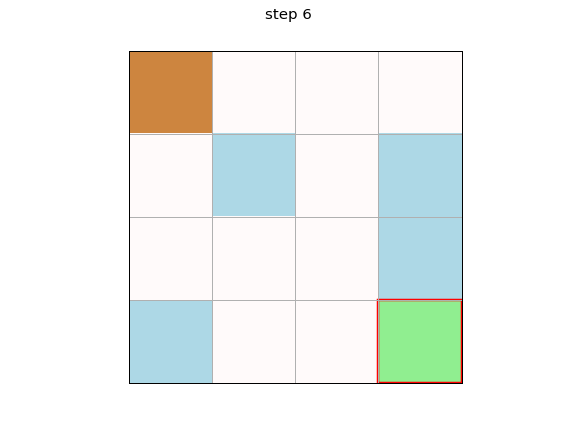

In [9]:
from time import sleep

def plot_step(percept):
    global step
    step += 1
    env.plot(show_state=True, update=True, 
             title= "step " + str(step))
    sleep(1)  # wait 1 second

env.reset()
env.plot(show_state=True)
sleep(1)
step = 0
episode = agent.walk(policy, update_function=plot_step)

The Percept object passed to the update function "plot_step" was not used here, but is required. The optional argument "update" of the "plot" method of class FrozenLake is used to update the existing plot instead of creating a new one. Note that method "step" also accepts the optional "update_function" argument. Function "sleep" is imported from package "time" and applied to slow down the execution.

### Stochastic policy 

A stochastic policy can also be represented by a matrix with the number of rows equal to the number of states and the number of columns equal to the number of actions. In this case, the entries of a row correspond to the probability distribution from which the next action is sampled. This means the sum of all entries must be equal to 1. Note that this requirement also holds for deterministic policies.

As an example, a stochastic policy is defined in which the possible actions for each state that can lead to winning the game, have equal probability of being selected. For instance, in the starting position, it is possible to go south or east, both with a probability of 50%. The probability matrix representing this policy will be constructed using a dictionary with possible actions (items) for all non-terminal states (keys):

In [10]:
P = np.zeros((env.nstates, env.nactions))

possible_actions = {0: (1, 2), 
                    1: (0, 2), 
                    2: (0, 1, 2),
                    3: (0, ),
                    4: (1, 3), 
                    6: (1, 3),
                    8: (2, 3), 
                    9: (0, 1, 2),
                    10: (0, 1, 3),
                    13: (2, 3),
                    14: (0, 2, 3)}

for state, actions in possible_actions.items():
    P[state, actions] = 1/len(actions)
    
print("Probability matrix P:")
print(P)
print("\nCheck if the sum of non-terminal state rows is 1:")
print(np.sum(P, axis=1))

Probability matrix P:
[[0.         0.5        0.5        0.        ]
 [0.5        0.         0.5        0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.         0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.         0.         0.         0.        ]]

Check if the sum of non-terminal state rows is 1:
[1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.]


Using probability matrix P, a new "Policy" object is defined:

In [11]:
policy = Policy(P, env)

Finally, this "Policy" object is used to let the agent walk in the FrozenLake environment in a stochastic way but without falling into a hole. The agent's steps are plotted applying the "plot_step" function written earlier:

<IPython.core.display.Javascript object>


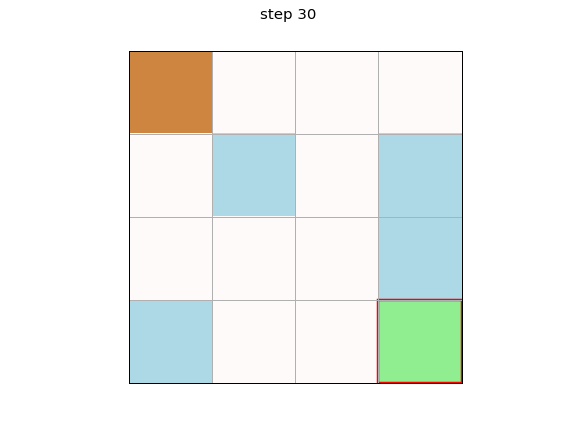

In [12]:
env.reset()
env.plot(show_state=True)
sleep(0.1)
step = 0
episode = agent.walk(policy, update_function=plot_step)

It can take some time now until the agent reaches the final stage, but eventually he will... or not?? 

To check this, a large number of episodes, e.g. 1000, will be run using the "run" method of the "Agent" class:

In [13]:
episodes = agent.run(policy, num_of_episodes=1000)

Method "run" returns a list of Episode objects. This output can be used to check how many steps the agent needed in each episode to reach the final state:

In [14]:
nsteps = [episode.n for episode in episodes]
print("maximum number of steps " + str(max(nsteps)))

maximum number of steps 100


The maximum number of steps will never be more than 100. That is because the original FrozenLake-v0 environment is time limited and stops the game if the maximum number of steps equal to 100 is exceeded. So, the stochastic policy doesn't garantee the game will be won, as it doesn't always bring the agent in the final state on time. The number of wins is calculated as follows:

In [15]:
is_a_win = [(episode.percepts[episode.n-1, 3] == 15) for episode in episodes]
print("number of wins: " + str(sum(is_a_win)))

number of wins: 879


Class "FrozenLake" has a static method "num_of_wins" that calculates the number of victories in the same way:

In [16]:
print("number of wins: " + str(FrozenLake.num_of_wins(episodes)))

number of wins: 879


If the environment was not time limited, then the number of wins would be 100.

### Uniform random policy 

A special case of the stochastic policies is the uniform random policy. This policy assigns an equal probability to all possible actions in a given state. Because it is frequently used, the "ReinforcementLearning" module provides a class "UniformRandomPolicy", which is a subclass of the "Policy" class: 

In [17]:
policy = UniformRandomPolicy(env)  # UniformRandomPolicy(env.nstates, env.nactions) is also possible

In the case of FrozenLake, there are 4 possible actions in each state, each of them having a probability of 25%:

In [18]:
print(policy.prob)

[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]


When the agent runs 100 episodes following the uniform random policy, the number of wins is very low:

In [19]:
episodes = agent.run(policy, num_of_episodes=100)
print("number of wins: " + str(env.num_of_wins(episodes)))

number of wins: 3


The uniform random policy can also be applied in a stochastic environment:

In [20]:
env = FrozenLake.make(is_slippery=True)  # is_slippery=True -> stochastic!
agent = Agent(env)
policy = UniformRandomPolicy(env)

episodes = agent.run(policy, 100)

print("number of wins: " + str(env.num_of_wins(episodes)))

number of wins: 2


In the stochastic case, the number of wins is also disappointing. Time to discuss methods to optimize the policy!